# Jessie Xie(21918545)
# Decision trees

> Note: use the X_train, X_val, X_test, y_train, y_val, y_test from github to keep consistent <br>
>
> The purpose of the notebook is to focus on **the Absorbance data with frequencies only**, and try different resampling methods and a feature selection method. <br>

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
#import graphviz 

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
# Read in the csv file
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (152, 332)
y_train shape (152, 1)
X_val shape (39, 332)
y_val shape (39, 1)
X_test shape (48, 332)
y_test shape (48, 1)


In [3]:
# Select frequenies
X_train = X_train.filter(regex='fa',axis=1)
X_val = X_val.filter(regex='fa',axis=1)
X_test = X_test.filter(regex='fa', axis=1)

print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)
print("X_test shape", X_test.shape)

X_train shape (152, 107)
X_val shape (39, 107)
X_test shape (48, 107)


In [4]:
# view the distribution of OverallPoF of the training set and test set as the baseline
print("The percentage of pass (training set): ", sum(y_train['OverallPoF']==0)/len(y_train["OverallPoF"]))
print("The percentage of fail (training set):", sum(y_train['OverallPoF']==1)/len(y_train["OverallPoF"]))
print("The percentage of pass (val set): ", sum(y_val['OverallPoF']==0)/len(y_val["OverallPoF"]))
print("The percentage of fail (val set):", sum(y_val['OverallPoF']==1)/len(y_val["OverallPoF"]))
print("The percentage of pass (test set): ", sum(y_test['OverallPoF']==0)/len(y_test["OverallPoF"]))
print("The percentage of fail (test set):", sum(y_test['OverallPoF']==1)/len(y_test["OverallPoF"]))

The percentage of pass (training set):  0.8552631578947368
The percentage of fail (training set): 0.14473684210526316
The percentage of pass (val set):  0.7692307692307693
The percentage of fail (val set): 0.23076923076923078
The percentage of pass (test set):  0.8541666666666666
The percentage of fail (test set): 0.14583333333333334


# 1. Dimensionality reduction (feature selection)

## 1.1. Remove constant features

In [5]:
# using sklearn variancethreshold to find constant features
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [6]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
print("The number of features that are not constant:",sum(sel.get_support()))

The number of features that are not constant: 107


> Comment: no features are constant.

## 1.2. Removing quasi-constant features

In [7]:
var_thres = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
var_thres.fit(X_train)  # fit finds the features with low variance
print("The number of features that are not quasi-constant:",sum(var_thres.get_support()))

The number of features that are not quasi-constant: 86


In [8]:
# print the quasi-constant features
print(
    len([
        x for x in X_train.columns
        if x not in X_train.columns[var_thres.get_support()]
    ]))

[x for x in X_train.columns if x not in X_train.columns[var_thres.get_support()]]

21


['fa226',
 'fa257',
 'fa280',
 'fa297',
 'fa324',
 'fa343',
 'fa363',
 'fa385',
 'fa408',
 'fa432',
 'fa458',
 'fa471',
 'fa500',
 'fa514',
 'fa545',
 'fa561',
 'fa577',
 'fa594',
 'fa629',
 'fa648',
 'fa667']

In [9]:
# remove the features from training and test set
new_cols = var_thres.get_support()
X_train = X_train.iloc[:, new_cols]
X_val = X_val.iloc[:, new_cols]
X_test = X_test.iloc[:, new_cols]

# check the shape of training and val set
print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)
print("X_test shape", X_test.shape)

X_train shape (152, 86)
X_val shape (39, 86)
X_test shape (48, 86)


## 1.3. Remove correlated features

In [10]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.995) # With tree-based models, we can safely ignore correlation issues. Therefore, I set a very high threshold.
print('The number of correlated features: ', len(set(corr_features)) )

The number of correlated features:  10


In [11]:
# removed highly correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_val.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

# check the shape of training and val set
print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)
print("X_test shape", X_val.shape)

X_train.to_csv('X_train_afterFilterFeatures.csv', index=False)
X_val.to_csv('X_val_afterFilterFeatures.csv', index=False)
X_test.to_csv('X_test_afterFilterFeatures.csv', index=False)

X_train shape (152, 76)
X_val shape (39, 76)
X_test shape (39, 76)


# 2. Handling imbalenced dataset

In [12]:
def dataset_barplot(y_data, title):
    pass_ = sum(y_data['OverallPoF']==0)
    fail_ = sum(y_data['OverallPoF']==1)
    PoF = ['Pass', "Fail"]
    count = [pass_, fail_]
    data = [go.Bar(
    x = PoF,
    y = count
    )] 
    fig = go.Figure(data=data)
    fig.update_layout(
        title=title)
    fig.show()
    return fig

## 2.1. NearMiss Under-sampling

In [14]:
nearmiss = NearMiss(sampling_strategy = 'majority', version = 2, n_jobs = -1)
X_nm, y_nm = nearmiss.fit_resample(X_train, y_train)
fig = dataset_barplot(y_nm, 'NearMiss Under-sampling')
fig.write_html('plots/DT/NM_bar.html')
print("The count of pass (NearMiss Under-sampling):", sum(y_nm['OverallPoF']==0))
print("The count of fail (NearMiss Under-sampling):", sum(y_nm['OverallPoF']==1))

The count of pass (NearMiss Under-sampling): 22
The count of fail (NearMiss Under-sampling): 22


## 1.2. SMOTE Over-sampling

In [15]:
smote = SMOTE(sampling_strategy = 'minority', random_state = 12)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
fig = dataset_barplot(y_smote, 'SMOTE Over-sampling')
fig.write_html('plots/DT/SMOTE_OS_bar.html')
print("The count of pass (SMOTE Over-sampling):", sum(y_smote['OverallPoF']==0))
print("The count of fail (SMOTE Over-sampling):", sum(y_smote['OverallPoF']==1))

The count of pass (SMOTE Over-sampling): 130
The count of fail (SMOTE Over-sampling): 130


## 1.3. SMOTEENN

In [16]:
smoteenn = SMOTEENN(sampling_strategy = 'auto', random_state = 12, smote = smote)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
fig = dataset_barplot(y_smoteenn, 'SMOTEENN')
fig.write_html('plots/DT/SMOTEENN_bar.html')
print("The count of pass (SMOTEENN):", sum(y_smoteenn['OverallPoF']==0))
print("The count of fail (SMOTEENN):", sum(y_smoteenn['OverallPoF']==1))

The count of pass (SMOTEENN): 84
The count of fail (SMOTEENN): 117


## 1.4. SMOTETomek

In [17]:
smotetomek = SMOTETomek(sampling_strategy = 'auto', random_state = 12,smote = smote)
X_smotetomek, y_smotetomek = smotetomek.fit_resample(X_train, y_train)
fig = dataset_barplot(y_smotetomek, 'SMOTETomek')
fig.write_html('plots/DT/SMOTETomek_bar.html')
print("The count of pass (SMOTETomek):", sum(y_smotetomek['OverallPoF']==0))
print("The count of fail (SMOTETomek):", sum(y_smotetomek['OverallPoF']==1))

The count of pass (SMOTETomek): 129
The count of fail (SMOTETomek): 129


# 3. SelectKBest (for later comparison)

In [18]:
def plot_important_features( X_dataset, y_dataset, title):
    '''
    plot features importance based on SelectKBest
    '''
    selectbest = SelectKBest(chi2, k=36) # select the 36 best features, because when I remove correlated variables with a 0.99 threshold, the number of remained variables is 36.
    fit = selectbest.fit(X_dataset, y_dataset)

    # Get the indices sorted by most important to least important
    indices = np.argsort(fit.scores_)[::-1]

    # To get the top 10 feature names
    features = []
    for i in range(10):
        features.append(X_dataset.columns[indices[i]])

    scores = fit.scores_[indices[range(10)]]

    fig = go.Figure(go.Bar(
                x=scores,
                y=features,
                orientation='h'))
    fig.update_layout(
        title=title,
        yaxis=dict(autorange="reversed"))
    fig.show()
    return fig


## 3.1. NearMiss Under-sampling dataset

In [19]:
fig = plot_important_features(X_nm, y_nm, "Top10 features (NearMiss Under-sampling dataset)")
fig.write_html('plots/SelectKBest/NM_TopFeatures.html')

##  3.2. SMOTE Over-sampling

In [20]:
fig = plot_important_features(X_smote, y_smote, "Top10 features (SMOTE Over-sampling)")
fig.write_html('plots/SelectKBest/SMOTE_OS_TopFeatures.html')

## 3.3. SMOTEENN

In [21]:
fig = plot_important_features(X_smoteenn, y_smoteenn, "Top 10 feaures (SMOTEENN)")
fig.write_html('plots/SelectKBest/SMOTEENN_TopFeatures.html')

## 3.4. SMOTETomek

In [22]:
fig = plot_important_features(X_smotetomek, y_smotetomek, "Top 10 features (SMOTETomek)")
fig.write_html('plots/SelectKBest/SMOTETomek_TopFeatures.html')

# 4. Decision tree

In [23]:
def dtree_grid_search(X,y,nfolds):
    '''
    Hyperparameter Tuning with GridSearchCV
    '''
    # create a dictionary of all values we want to test
    param_grid = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
    # decision tree model
    dtree_model=DecisionTreeClassifier(random_state=12)
    # use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, return_train_score=True)
    # fit model to data
    dtree_gscv.fit(X, y)
    # find the best params
    best_params = dtree_gscv.best_params_
    # see the mean test score for each parameter
    scores = dtree_gscv.cv_results_['mean_test_score']
    params = dtree_gscv.cv_results_['params']
    zippedList = list(zip(scores, params))
    df_scores = pd.DataFrame(zippedList, columns = ['scores', 'params'])  
    df_scores = df_scores.sort_values(by=['scores'],ascending=False,ignore_index=True)
    return best_params, df_scores, dtree_gscv 



def plot_search_results(grid):
    '''
    plot the grid search result
    '''
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [24]:
def decision_tree(X, y, X_test, y_test, criterion, max_depth):
    '''
    fit a decision tree model
    '''
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=12)
    # fit model to data
    clf.fit(X, y)
    # predict val data
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # accuracy and classification report
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    report_train = classification_report(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, average='macro')
    report = classification_report(y_test, y_pred_test)
    return clf, accuracy_train,recall_train, report_train, accuracy,recall, report
    

def plot_decision_tree(X_train, model):
    '''
    plot the decision tree
    '''
    # find the name of features of the training dataset
    X_train_name = X_train.columns.to_list()
    fig = plt.figure(figsize=(12,10))
    _ = tree.plot_tree(model, feature_names=X_train_name, class_names=['pass', 'fail'], filled=True)

In [25]:
def plot_important_features_DT(model, top_n, X_dataset, y_dataset, title):
    '''
    plot the important features based on a decision tree
    '''
    fit = model.fit(X_dataset, y_dataset)
    # Get the indices sorted by most important to least important
    indices = np.argsort(fit.feature_importances_)[::-1]

    # To get the top n feature names
    features = []
    for i in range(top_n):
        features.append(X_dataset.columns[indices[i]])

    scores = fit.feature_importances_[indices[range(top_n)]]
    scores = [ round(s, 3) for s in scores ]

    fig = go.Figure(go.Bar(
                x=scores,
                y=features,
                orientation='h'))
    fig.update_layout(
        title=title,
        yaxis=dict(autorange="reversed"))
    fig.show()

    return features, scores, fig


In [26]:
def plot_cm (model, X_test, y_test, name):
    '''
    plot a confusion matrix
    '''
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = np.trace(cm) / float(np.sum(cm)) # calculate accuracy
    misclass = 1 - accuracy # calculate misclass

    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    ax.set_ylabel('Actual Class ')
    ## Ticket labels 
    ax.xaxis.set_ticklabels(['pass', 'fail'])
    ax.yaxis.set_ticklabels(['pass', 'fail'])
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()


def plot_roc(model,X_test, y_test, name):
    '''
    plot roc curve
    '''
    y_pred = model.predict(X_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(6,6))
    plt.title(f'Receiver Operating Characteristic - {name}')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [27]:
# define an empty list to save results
results = []

## 4.1. NearMiss Under-sampling dataset

In [28]:
# grid search
best_params_nm, scores_nm, grid_nm = dtree_grid_search(X_nm,y_nm,5)
print(best_params_nm)
scores_nm.head(3)

{'criterion': 'entropy', 'max_depth': 3}


,scores,params
0,0.933333,"{'criterion': 'entropy', 'max_depth': 3}"
1,0.933333,"{'criterion': 'entropy', 'max_depth': 4}"
2,0.933333,"{'criterion': 'entropy', 'max_depth': 13}"


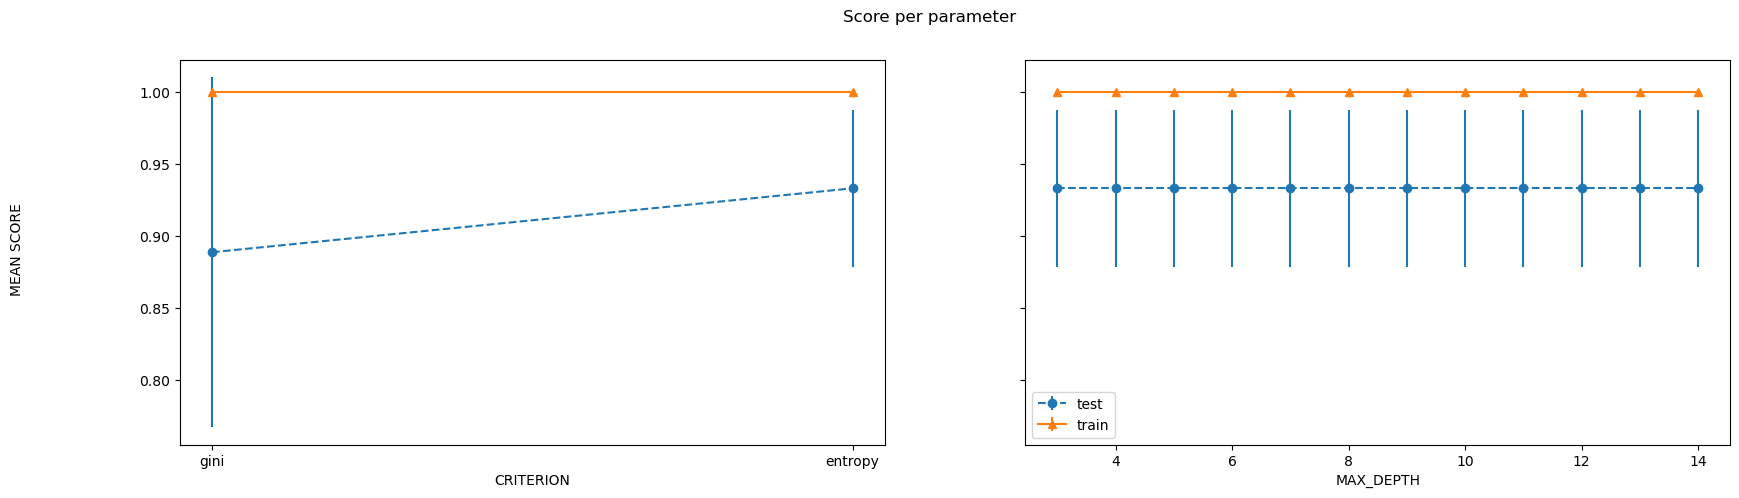

In [29]:
# plot grid search results
plot_search_results(grid_nm)

In [30]:
# Use "best params" for the decision tree
clf_nm, accuracy_train_nm, recall_train_nm, report_train_nm, accuracy_nm, recall_nm, report_nm = decision_tree(X_nm, y_nm, X_val, y_val, "entropy", 3) 

print("Accuracy (Training set - NearMiss Under-sampling):", accuracy_train_nm)
print("\nClassification Report (Training set - NearMiss Under-sampling)")
print(report_train_nm)

print("Accuracy (Validation set - NearMiss Under-sampling):", accuracy_nm)
print("\nClassification Report (Validation set - NearMiss Under-sampling)")
print(report_nm)

Accuracy (Training set - NearMiss Under-sampling): 0.48026315789473684

Classification Report (Training set - NearMiss Under-sampling)
              precision    recall  f1-score   support

           0       1.00      0.39      0.56       130
           1       0.22      1.00      0.36        22

    accuracy                           0.48       152
   macro avg       0.61      0.70      0.46       152
weighted avg       0.89      0.48      0.53       152

Accuracy (Validation set - NearMiss Under-sampling): 0.46153846153846156

Classification Report (Validation set - NearMiss Under-sampling)
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        30
           1       0.30      1.00      0.46         9

    accuracy                           0.46        39
   macro avg       0.65      0.65      0.46        39
weighted avg       0.84      0.46      0.46        39



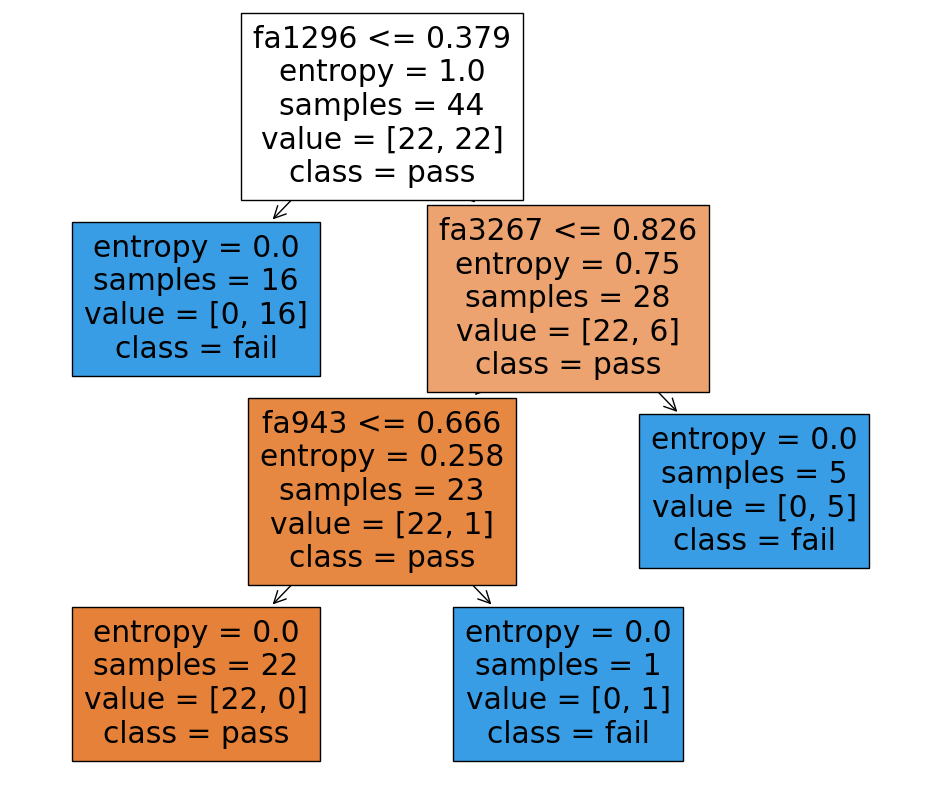

In [31]:
# plot the decision tree
plot_decision_tree(X_nm, clf_nm)

In [32]:
# plot feature importance based on the decision tree model
features_nm, scores_nm, fig = plot_important_features_DT(clf_nm, 3, X_nm, y_nm, 'NearMiss Under-sampling')
fig.write_html('plots/DT/NM_TopFeatures.html')

In [33]:
results.append({
        'best_params': best_params_nm,
        'accuracy(train)': accuracy_train_nm,
        'recall(train)': recall_train_nm,
        'accuracy(val)': accuracy_nm,
        'recall(val)': recall_nm,
        'features': features_nm,
        'socres': scores_nm,
})

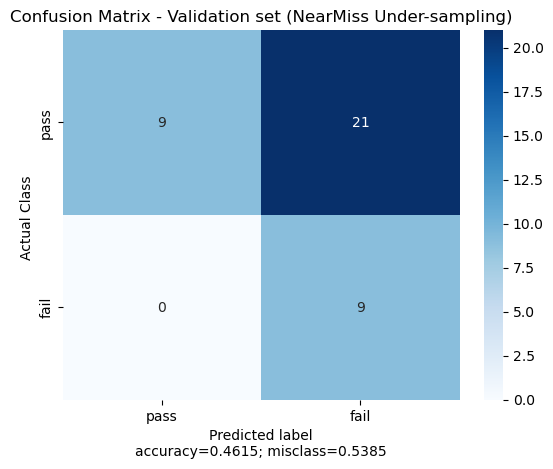

In [34]:
# plot a confusion matrix
plot_cm (clf_nm, X_val, y_val, "Validation set (NearMiss Under-sampling)")

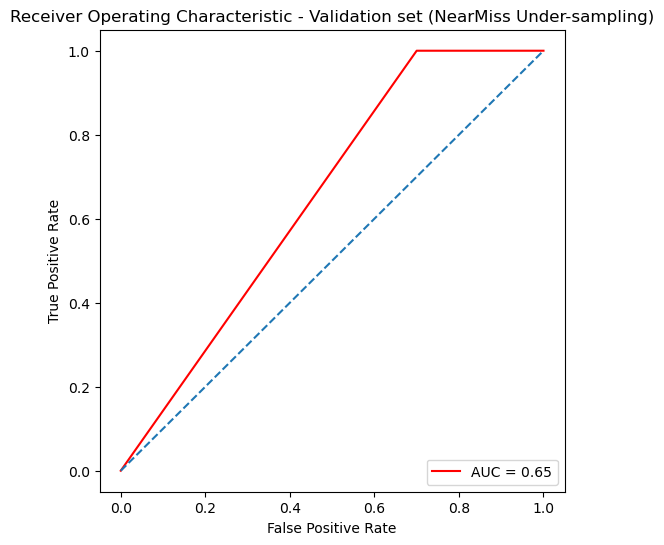

In [35]:
# plot ROC curve
plot_roc(clf_nm, X_val, y_val,"Validation set (NearMiss Under-sampling)")

## 4.2. SMOTE Over-sampling

In [36]:
# grid search
best_params_smote, scores_smote, grid_smote = dtree_grid_search(X_smote,y_smote,5)
print(best_params_smote)
scores_smote.head(3)

{'criterion': 'gini', 'max_depth': 4}


,scores,params
0,0.884615,"{'criterion': 'gini', 'max_depth': 4}"
1,0.876923,"{'criterion': 'entropy', 'max_depth': 4}"
2,0.865385,"{'criterion': 'entropy', 'max_depth': 5}"


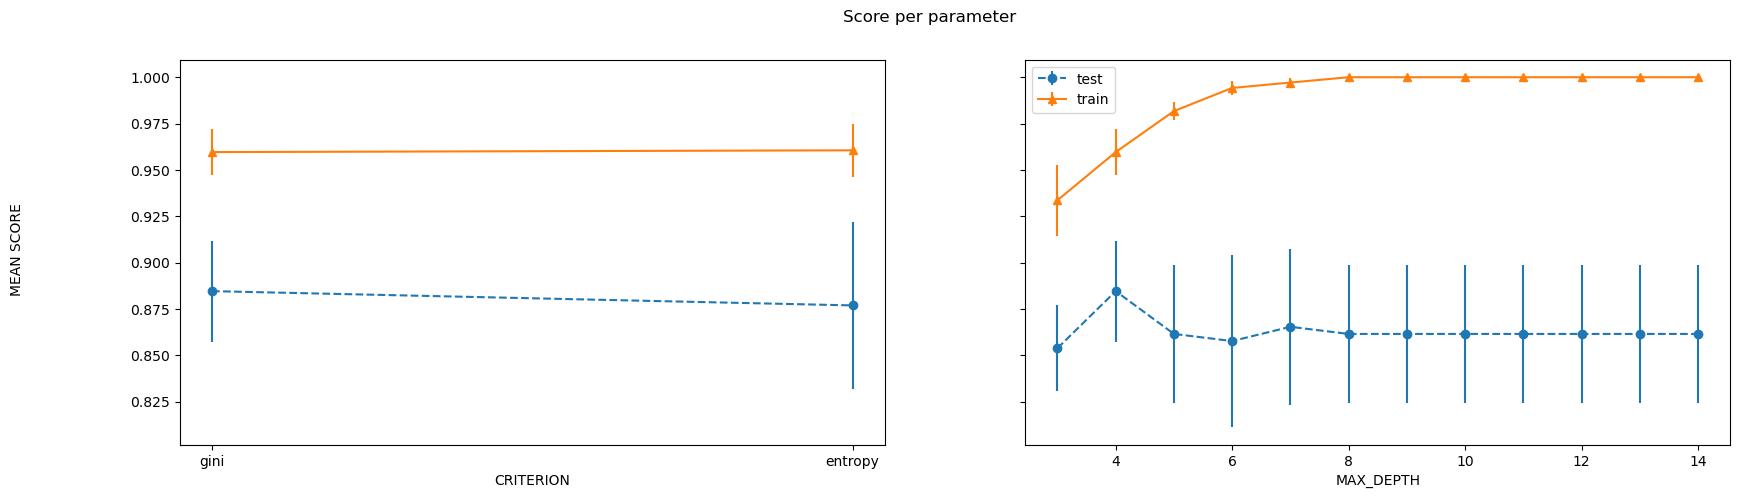

In [37]:
# plot grid search results
plot_search_results(grid_smote)

In [38]:
# Use "best params" for the decision tree
clf_smote, accuracy_train_smote, recall_train_smote, report_train_smote, accuracy_smote, recall_smote, report_smote = decision_tree(X_smote, y_smote, X_val, y_val, "gini", 4) 

print("Accuracy (Training set - SMOTE Over-sampling):", accuracy_train_smote)
print("\nClassification Report (Training set - SMOTE Over-sampling)")
print(report_train_smote)

print("Accuracy (Validation set - SMOTE Over-sampling):", accuracy_smote)
print("\nClassification Report (Validation set - SMOTE Over-sampling)")
print(report_smote)

Accuracy (Training set - SMOTE Over-sampling): 0.9473684210526315

Classification Report (Training set - SMOTE Over-sampling)
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       130
           1       0.77      0.91      0.83        22

    accuracy                           0.95       152
   macro avg       0.88      0.93      0.90       152
weighted avg       0.95      0.95      0.95       152

Accuracy (Validation set - SMOTE Over-sampling): 0.8461538461538461

Classification Report (Validation set - SMOTE Over-sampling)
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.64      0.78      0.70         9

    accuracy                           0.85        39
   macro avg       0.78      0.82      0.80        39
weighted avg       0.86      0.85      0.85        39



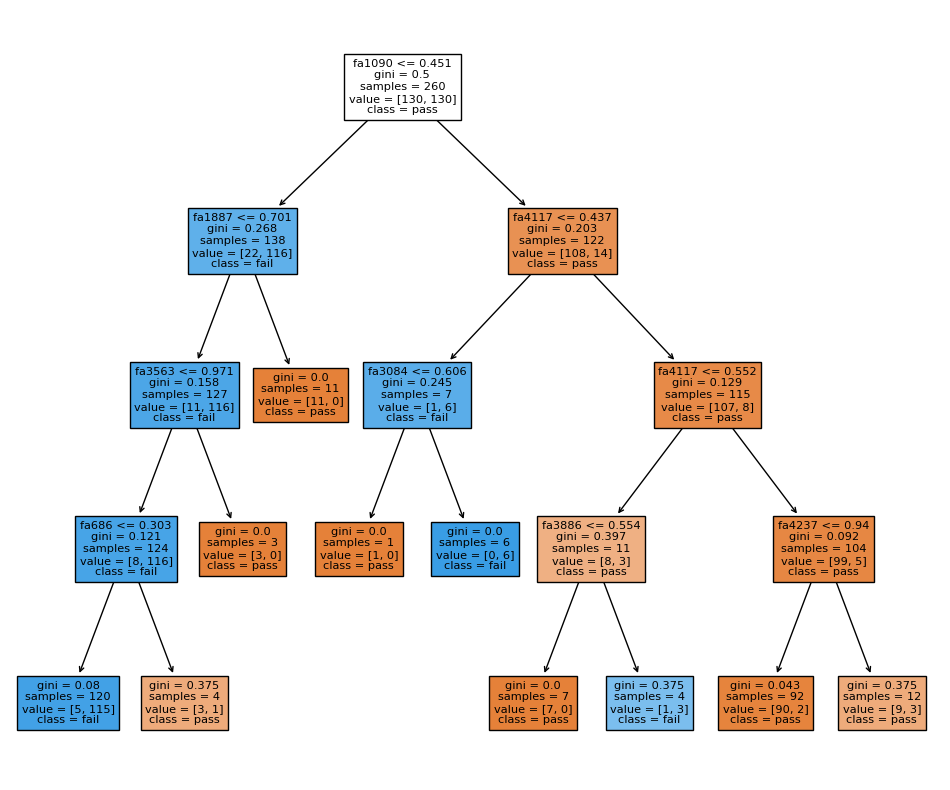

In [39]:
# plot the decision tree
plot_decision_tree(X_smote, clf_smote)

In [40]:
# plot feature importance based on the decision tree model
features_smote, scores_smote, fig = plot_important_features_DT(clf_smote, 8, X_smote, y_smote, 'SMOTE Over-sampling') 
fig.write_html('plots/DT/SMOTE_OS_TopFeatures.html')

In [41]:
results.append({
        'best_params': best_params_smote,
        'accuracy(train)': accuracy_train_smote,
        'recall(train)': recall_train_smote,
        'accuracy(val)': accuracy_smote,
        'recall(val)': recall_smote,
        'features': features_smote,
        'socres': scores_smote,
})

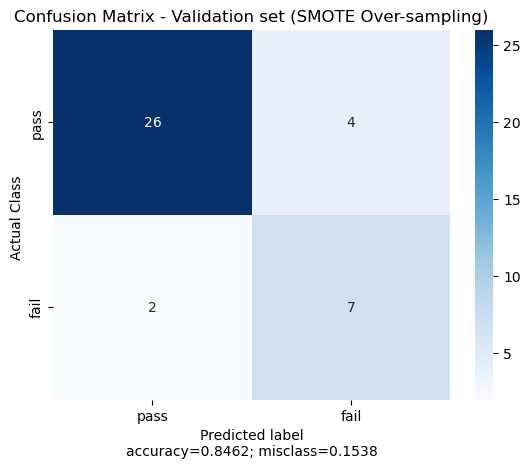

In [42]:
# plot a confusion matrix
plot_cm(clf_smote, X_val, y_val, "Validation set (SMOTE Over-sampling)")

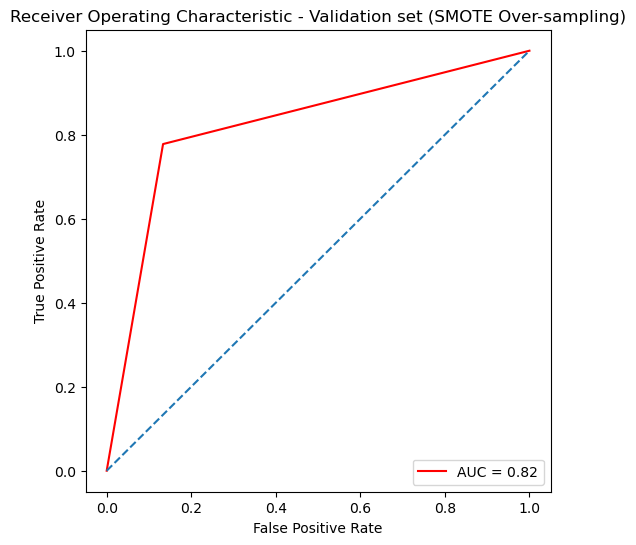

In [43]:
# plot ROC curve
plot_roc(clf_smote, X_val, y_val, "Validation set (SMOTE Over-sampling)")

## 3.3. SMOTEENN

In [44]:
# grid search
best_params_smoteenn, scores_smoteenn, grid_smoteenn = dtree_grid_search(X_smoteenn,y_smoteenn,5)
print(best_params_smoteenn)
scores_smoteenn.head(3)

{'criterion': 'entropy', 'max_depth': 3}


,scores,params
0,0.955244,"{'criterion': 'entropy', 'max_depth': 3}"
1,0.950244,"{'criterion': 'entropy', 'max_depth': 4}"
2,0.950244,"{'criterion': 'entropy', 'max_depth': 13}"


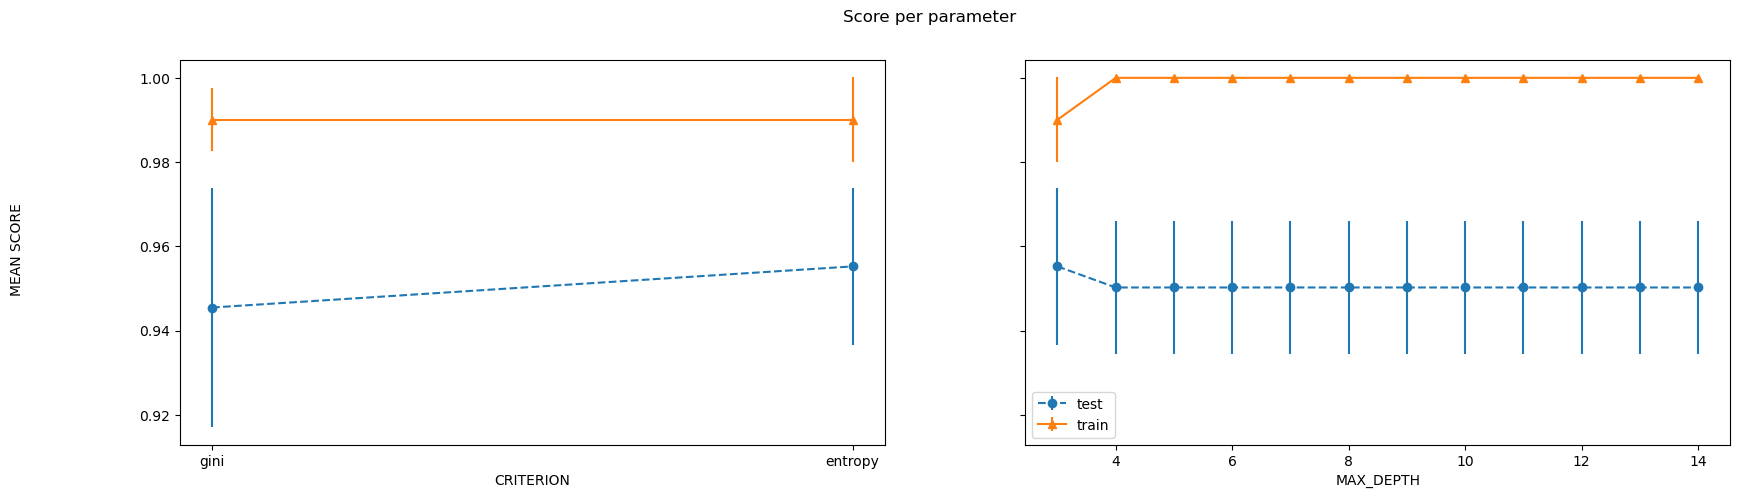

In [45]:
# plot grid search results
plot_search_results(grid_smoteenn)

In [46]:
# Use "best params" for the decision tree
clf_smoteenn, accuracy_train_smoteenn,recall_train_smoteenn, report_train_smoteenn, accuracy_smoteenn, recall_smoteenn, report_smoteenn = decision_tree(X_smoteenn, y_smoteenn, X_val, y_val, "entropy", 3) 

print("Accuracy (Training set - SMOTEENN):", accuracy_train_smoteenn)
print("\nClassification Report (Training set - SMOTEENN)")
print(report_train_smoteenn)

print("Accuracy (Validation set - SMOTEENN:", accuracy_smoteenn)
print("\nClassification Report (Validation set - SMOTEENN)")
print(report_smoteenn)

Accuracy (Training set - SMOTEENN): 0.9013157894736842

Classification Report (Training set - SMOTEENN)
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       130
           1       0.61      0.91      0.73        22

    accuracy                           0.90       152
   macro avg       0.79      0.90      0.83       152
weighted avg       0.93      0.90      0.91       152

Accuracy (Validation set - SMOTEENN: 0.8461538461538461

Classification Report (Validation set - SMOTEENN)
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.64      0.78      0.70         9

    accuracy                           0.85        39
   macro avg       0.78      0.82      0.80        39
weighted avg       0.86      0.85      0.85        39



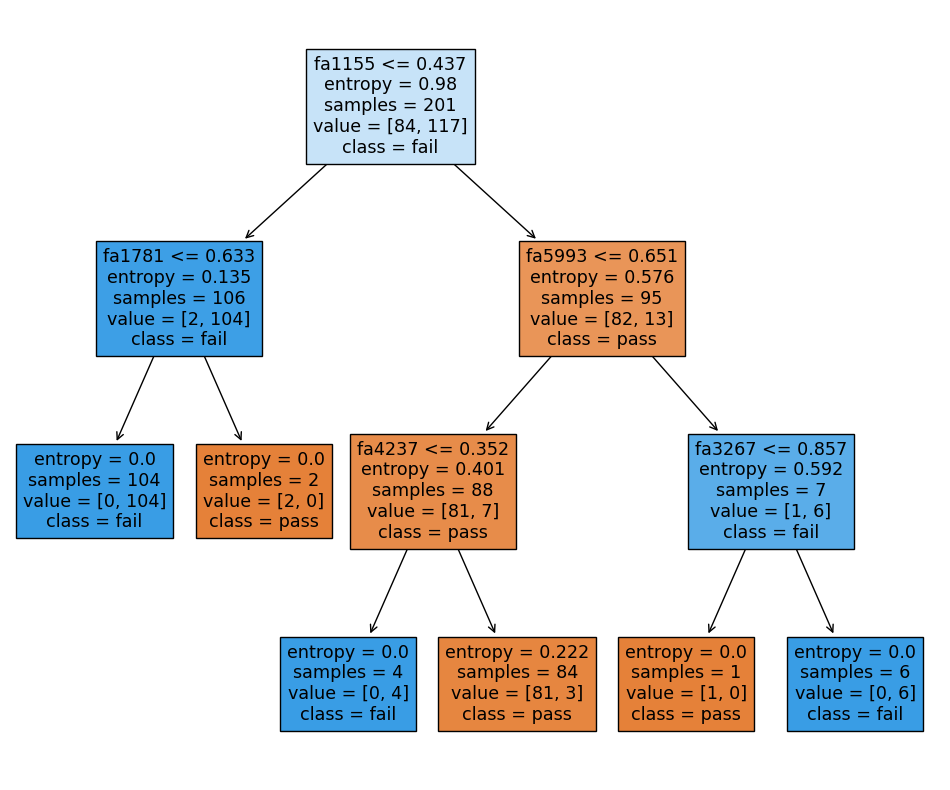

In [47]:
# plot the decision tree
plot_decision_tree(X_smoteenn, clf_smoteenn)

In [48]:
# plot feature importance based on the decision tree model
features_smoteenn, scores_smoteenn, fig = plot_important_features_DT(clf_smoteenn, 5, X_smoteenn, y_smoteenn, 'SMOTEENN')
fig.write_html('plots/DT/SMOTEENN_TopFeatures.html')

In [49]:
results.append({
        'best_params': best_params_smoteenn,
        'accuracy(train)': accuracy_train_smoteenn,
        'recall(train)': recall_train_smoteenn,       
        'accuracy(val)': accuracy_smoteenn,
        'recall(val)': recall_smoteenn,
        'features': features_smoteenn,
        'socres': scores_smoteenn,
})

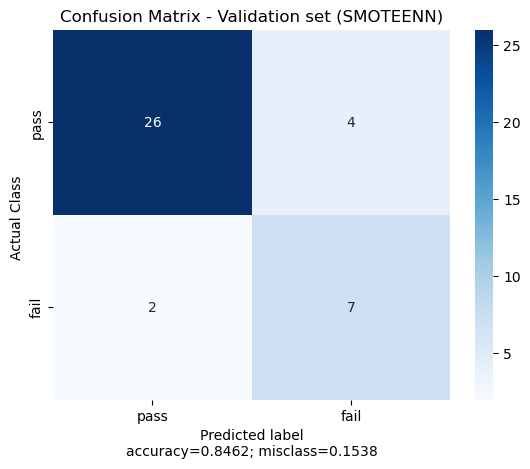

In [50]:
# plot a confusion matrix
plot_cm(clf_smoteenn, X_val, y_val, "Validation set (SMOTEENN)")

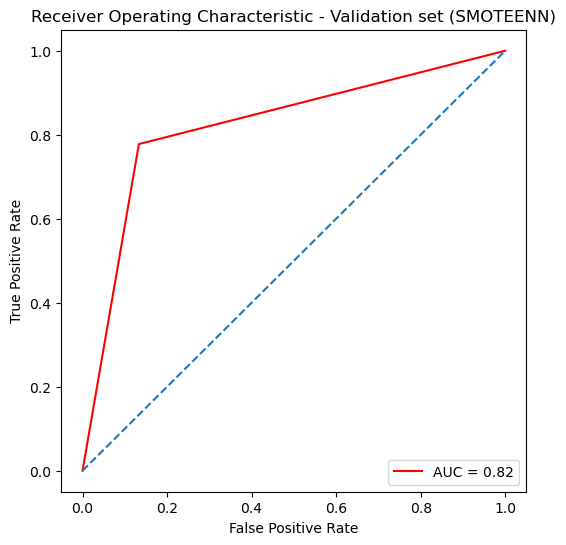

In [51]:
# plot ROC curve
plot_roc(clf_smoteenn, X_val, y_val, "Validation set (SMOTEENN)")

## 4.4. SMOTETomek

In [52]:
# grid search
best_params_smotetomek, scores_smotetomek, grid_smotetomek = dtree_grid_search(X_smotetomek,y_smotetomek,5)
print(best_params_smotetomek)
scores_smotetomek.head(3)

{'criterion': 'gini', 'max_depth': 4}


,scores,params
0,0.876094,"{'criterion': 'gini', 'max_depth': 4}"
1,0.872323,"{'criterion': 'gini', 'max_depth': 7}"
2,0.872323,"{'criterion': 'gini', 'max_depth': 8}"


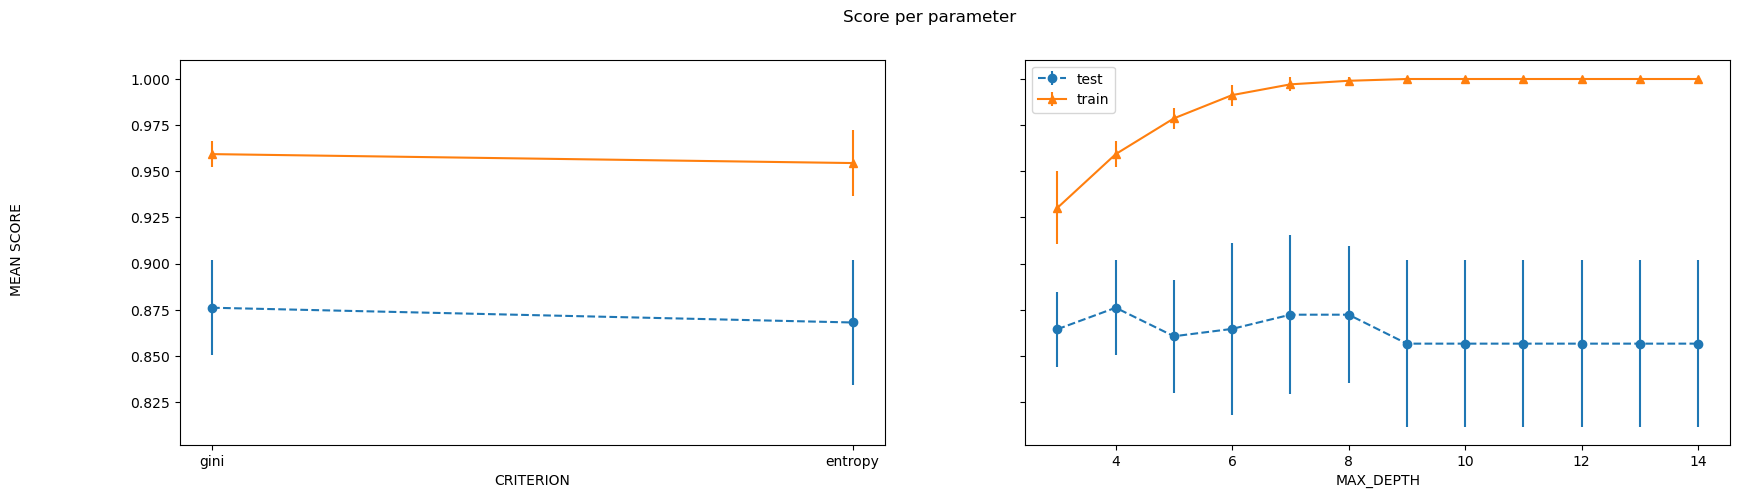

In [53]:
# plot grid search results
plot_search_results(grid_smotetomek)

In [54]:
# Use "best params" for the decision tree
clf_smotetomek, accuracy_train_smotetomek, recall_train_smotetomek,report_train_smotetomek, accuracy_smotetomek, recall_smotetomek, report_smotetomek = decision_tree(X_smotetomek, y_smotetomek, X_val, y_val, "gini", 4) 

print("Accuracy (Training set - SMOTETomek):", accuracy_train_smotetomek)
print("\nClassification Report (Training set - SMOTETomek")
print(report_train_smotetomek)

print("Accuracy (Validation set - SMOTETomek:", accuracy_smotetomek)
print("\nClassification Report (Validation set - SMOTETomek)")
print(report_smotetomek)

Accuracy (Training set - SMOTETomek): 0.9868421052631579

Classification Report (Training set - SMOTETomek
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       130
           1       1.00      0.91      0.95        22

    accuracy                           0.99       152
   macro avg       0.99      0.95      0.97       152
weighted avg       0.99      0.99      0.99       152

Accuracy (Validation set - SMOTETomek: 0.8461538461538461

Classification Report (Validation set - SMOTETomek)
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.64      0.78      0.70         9

    accuracy                           0.85        39
   macro avg       0.78      0.82      0.80        39
weighted avg       0.86      0.85      0.85        39



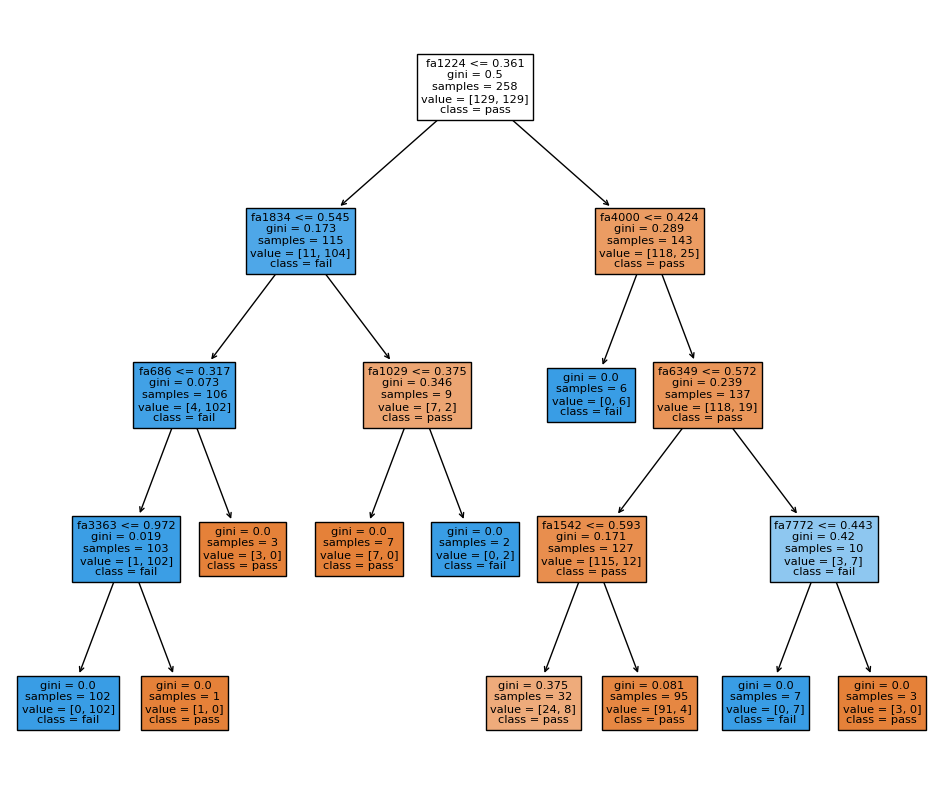

In [55]:
# plot the decision tree
plot_decision_tree(X_smotetomek, clf_smotetomek)

In [56]:
# plot feature importance based on the decision tree model
features_smotetomek, scores_smotetomek, fig = plot_important_features_DT(clf_smotetomek, 9, X_smotetomek, y_smotetomek, 'SMOTETomek')
fig.write_html('plots/DT/SMOTETomek_TopFeatures.html')

In [57]:
results.append({
        'best_params': best_params_smotetomek,
        'accuracy(train)': accuracy_train_smotetomek,
        'recall(train)': recall_train_smotetomek,
        'accuracy(val)': accuracy_smotetomek,
        'recall(val)': recall_smotetomek,
        'features': features_smotetomek,
        'socres': scores_smotetomek,
})

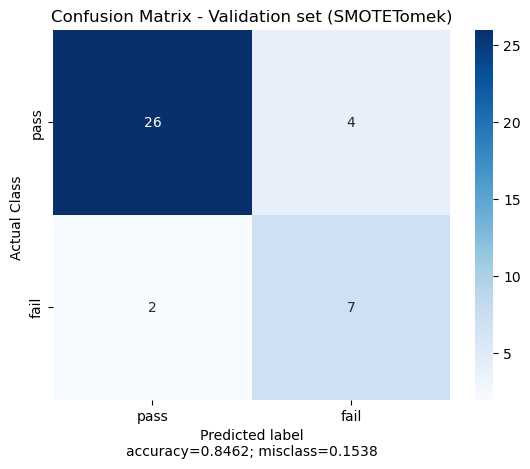

In [58]:
# plot a confusion matrix
plot_cm(clf_smotetomek, X_val, y_val, "Validation set (SMOTETomek)")

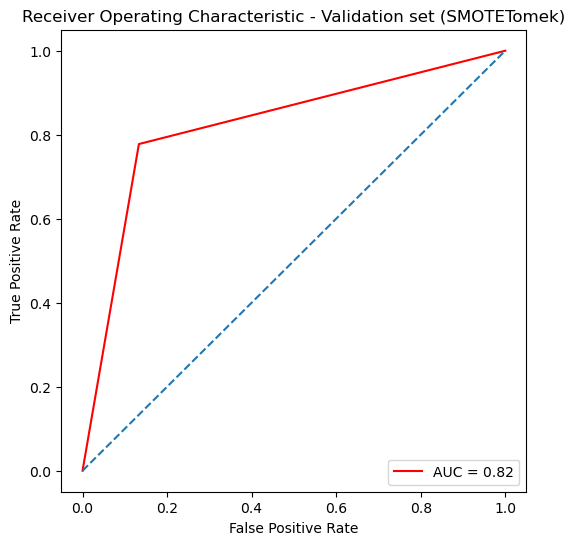

In [59]:
# plot ROC curve
plot_roc(clf_smotetomek, X_val, y_val, "Validation set (SMOTETomek)")

# 5. Summary

In [60]:
summary = pd.DataFrame(results)
summary

,best_params,accuracy(train),recall(train),accuracy(val),recall(val),features,socres
0,"{'criterion': 'entropy', 'max_depth': 3}",0.480263,0.696154,0.461538,0.650000,"[fa1296, fa3267, fa943]","[0.523, 0.342, 0.135]"
1,"{'criterion': 'gini', 'max_depth': 4}",0.947368,0.931469,0.846154,0.822222,"[fa1090, fa1887, fa4117, fa3563, fa686, fa3886...","[0.626, 0.155, 0.084, 0.047, 0.036, 0.026, 0.0..."
2,"{'criterion': 'entropy', 'max_depth': 3}",0.901316,0.904545,0.846154,0.822222,"[fa1155, fa4237, fa5993, fa1781, fa3267]","[0.718, 0.093, 0.086, 0.08, 0.023]"
3,"{'criterion': 'gini', 'max_depth': 4}",0.986842,0.954545,0.846154,0.822222,"[fa1224, fa1834, fa4000, fa6349, fa686, fa7772...","[0.621, 0.083, 0.078, 0.062, 0.052, 0.038, 0.0..."


> **SelectKBest**
> <table>
>   <thead>
>     <tr>
>       <th>Dataset</th>
>       <th>Top 3 features</th>
>       <th>Scores</th>
>     </tr>
>   </thead>
>   <tbody>
>     <tr>
>       <td>NearMiss Under-sampling</td>
>       <td>fa1224 </td>
>       <td>1.055 </td>
>     </tr>
>     <tr>
>       <td>NearMiss Under-sampling</td>
>       <td>fa1259 </td>
>       <td>1.020 </td>
>     </tr>
>     <tr>
>       <td>NearMiss Under-sampling</td>
>       <td>fa1296 </td>
>       <td>0.917 </td>
>     </tr>
>     <tr>
>       <td> </td>
>       <td> </td>
>       <td> </td>
>     </tr>
>     <tr>
>       <td>SMOTE Over-sampling</td>
>       <td>fa1224 </td>
>       <td>11.737 </td>
>     </tr>
>     <tr>
>       <td>SMOTE Over-sampling</td>
>       <td>fa1259 </td>
>       <td>11.525 </td>
>     </tr>
>     <tr>
>       <td>SMOTE Over-sampling</td>
>       <td>fa1296 </td>
>       <td>9.990 </td>
>     </tr>
>     <tr>
>       <td> </td>
>       <td> </td>
>       <td> </td>
>     </tr>
>     <tr>
>       <td>SMOTEENN</td>
>       <td>fa1224 </td>
>       <td>13.979 </td>
>     </tr>
>     <tr>
>       <td>SMOTEENN</td>
>       <td>fa1259 </td>
>       <td>13.440 </td>
>     </tr>
>     <tr>
>       <td>SMOTEENN</td>
>       <td>fa1189</td>
>       <td>11.883 </td>
>     </tr>
>     <tr>
>       <td> </td>
>       <td> </td>
>       <td> </td>
>     </tr>
>     <tr>
>       <td>SMOTETomek</td>
>       <td>fa1224</td>
>       <td>11.744 </td>
>     </tr>
>     <tr>
>       <td>SMOTETomek</td>
>       <td>fa1259</td>
>       <td>11.545 </td>
>     </tr>
>     <tr>
>       <td>SMOTETomek</td>
>       <td>fa1296</td>
>       <td>10.003 </td>
>     </tr>
>   </tbody>
> </table>
> <br>
>
> **Decision trees**
> <table>
>   <thead>
>     <tr>
>       <th>Dataset</th>
>       <th>Hyperparameters</th>
>       <th>Top 3 features</th>
>       <th>Feature importances</th>
>       <th>Accuracy on the validation set</th>
>       <th>Recall on the validation set</th>
>       <th>F1 on the validation set</th>
>       <th>AUC on the validation set</th>
>     </tr>
>   </thead>
>   <tbody>
>     <tr>
>       <td>NearMiss Under-sampling</td>
>       <td>{'criterion': 'entropy', 'max_depth': 3}</td>
>       <td>[fa1296, fa3267, fa943] </td>
>       <td>[0.523, 0.342, 0.135]</td>
>       <td>0.46</td>
>       <td>0.65</td>
>       <td>0.46</td>
>       <td>0.65</td>
>     </tr>
>     <tr>
>       <td>SMOTE Over-sampling</td>
>       <td>{'criterion': 'gini', 'max_depth': 4}</td>
>       <td>[fa1090, fa1887, fa4117] </td>
>       <td>[0.625, 0.155, 0.084]</td>
>       <td>0.85</td>
>       <td>0.82</td>
>       <td>0.80</td>
>       <td>0.82</td>
>     </tr>
>     <tr>
>       <td>SMOTEENN</td>
>       <td>{'criterion': 'entropy', 'max_depth': 3}</td>
>       <td>[fa1155, fa4237, fa5993] </td>
>       <td>[0.718, 0.093, 0.086]</td>
>       <td>0.85</td>
>       <td>0.82</td>
>       <td>0.80</td>
>       <td>0.82</td>
>     </tr>
>     <tr>
>       <td>SMOTETomek</td>
>       <td>{'criterion': 'gini', 'max_depth': 4}</td>
>       <td>[fa1224, fa1834, fa4000] </td>
>       <td>[0.621, 0.083, 0.078]</td>
>       <td>0.85</td>
>       <td>0.82</td>
>       <td>0.80</td>
>       <td>0.82</td>
>     </tr>
>   </tbody>
> </table>
> <br>
> In conclusion, decision trees provide different results based on different datasets, which may imply that a single decision tree is not reliable, therefore, I will try Random forests consisting of many decision trees.

# 6. Test the best model on the test set.

> Comment: <br>
> - I select the best model based on the highest recall. <br>
> - SMOTE, SMOTEENN, and SMOTETomek all produce the same recall score on the validation set. <br>

# 6.1. SMOTE Over-sampling

In [61]:
# test the best model on the test set
# predict test data
y_pred_train = clf_smote.predict(X_train)
y_pred_test = clf_smote.predict(X_test)
# accuracy and classification report
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print("Accuracy (Test set - SMOTE Over-sampling:", accuracy_test)
print("\nClassification Report (Test set - SMOTE Over-sampling)")
print(report_test)

Accuracy (Test set - SMOTE Over-sampling: 0.875

Classification Report (Test set - SMOTE Over-sampling)
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        41
           1       0.54      1.00      0.70         7

    accuracy                           0.88        48
   macro avg       0.77      0.93      0.81        48
weighted avg       0.93      0.88      0.89        48



# 6.2. SMOTEENN

In [62]:
# test the best model on the test set
# predict test data
y_pred_train = clf_smoteenn.predict(X_train)
y_pred_test = clf_smoteenn.predict(X_test)
# accuracy and classification report
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print("Accuracy (Test set - SMOTEENN:", accuracy_test)
print("\nClassification Report (Test set - SMOTEENN)")
print(report_test)

Accuracy (Test set - SMOTEENN: 0.8333333333333334

Classification Report (Test set - SMOTEENN)
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        41
           1       0.47      1.00      0.64         7

    accuracy                           0.83        48
   macro avg       0.73      0.90      0.76        48
weighted avg       0.92      0.83      0.85        48



# 6.3. SMOTETomek

In [63]:
# test the best model on the test set
# predict test data
y_pred_train = clf_smotetomek.predict(X_train)
y_pred_test = clf_smotetomek.predict(X_test)
# accuracy and classification report
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print("Accuracy (Test set - SMOTETomek:", accuracy_test)
print("\nClassification Report (Test set - SMOTETomek)")
print(report_test)

Accuracy (Test set - SMOTETomek: 0.8541666666666666

Classification Report (Test set - SMOTETomek)
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        41
           1       0.50      1.00      0.67         7

    accuracy                           0.85        48
   macro avg       0.75      0.91      0.79        48
weighted avg       0.93      0.85      0.87        48



> Comment:<br>
> - Over-sampling provides the highest recall on the test set.

# 7. Focus on selected features 

## 7.1. View the distribution of the originial data

In [64]:
# Merge back to the original data
X_train_org = pd.read_csv('X_train.csv')
y_train_org = pd.read_csv('y_train.csv')
X_val_org = pd.read_csv('X_val.csv')
y_val_org = pd.read_csv('y_val.csv')
X_test_org = pd.read_csv('X_test.csv')
y_test_org = pd.read_csv('y_test.csv')

# Select frequenies
X_train_org = X_train_org.filter(regex='fa',axis=1)
X_val_org = X_val_org.filter(regex='fa',axis=1)
X_test_org = X_test_org.filter(regex='fa', axis=1)

X_frames = [X_train_org, X_val_org, X_test_org]
y_frames = [y_train_org, y_val_org, y_test_org]
X_original = pd.concat(X_frames)
y_original = pd.concat(y_frames)

df = pd.concat([X_original, y_original], axis=1)
print("df shape", df.shape)

df shape (239, 108)


In [65]:
df.head(3)

,fa226,fa257,fa280,fa297,fa324,fa343,fa363,fa385,fa408,fa432,...,fa6349,fa6535,fa6727,fa6924,fa7127,fa7336,fa7550,fa7772,fa8000,OverallPoF
0,0.0620,0.0815,0.1046,0.1108,0.1006,0.0856,0.0826,0.0911,0.0999,0.0976,...,0.6934,0.7065,0.7411,0.7494,0.7475,0.7382,0.7570,0.7724,0.7484,0
1,0.0348,0.0649,0.0960,0.1098,0.1087,0.1043,0.1123,0.1316,0.1441,0.1446,...,0.1945,0.1307,0.1038,0.0963,0.0601,0.0519,0.0269,0.0382,0.0127,0
2,0.0026,0.0288,0.0561,0.0651,0.0592,0.0493,0.0542,0.0706,0.0803,0.0734,...,0.0185,0.0000,0.0000,0.0147,0.0000,0.0000,0.0000,0.0000,0.0000,0


In [66]:
# prepare the dataframe for plotting line graphs
df_plot=pd.melt(df,'OverallPoF')
df_plot['PoF'] = np.where(df_plot['OverallPoF']==0, 'Pass', 'Fail')
df_plot.rename({'variable':'frequencies', 'value':'absorbance'}, axis=1, inplace=True)
df_plot.head(3)

,OverallPoF,frequencies,absorbance,PoF
0,0,fa226,0.0620,Pass
1,0,fa226,0.0348,Pass
2,0,fa226,0.0026,Pass


In [67]:
fig = px.box(df_plot, x="frequencies", y="absorbance", color="PoF")
fig.show()
fig.write_html('plots/DT/ViewAll_box.html')

## 7.2. Focus on the selected features

In [68]:
def plot_lines(frequencies, df_plot):
    '''
    Plot the selected frequencies on the mean absorbance line curves with 95% CI
    '''
    # I also create a grouped version, with calculated mean and standard deviation.
    df_pass = df_plot[df_plot['PoF']=='Pass']
    df_fail = df_plot[df_plot['PoF']=='Fail'] 

    # pass group
    df_grouped_pass = (
        df_pass[['frequencies', 'absorbance']].groupby(['frequencies'], sort=False)
        .agg(['mean', 'std', 'count'])
    )
    df_grouped_pass = df_grouped_pass.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped_pass['ci'] = 1.96 * df_grouped_pass['std'] / np.sqrt(df_grouped_pass['count'])
    df_grouped_pass['ci_lower'] = df_grouped_pass['mean'] - df_grouped_pass['ci']
    df_grouped_pass['ci_upper'] = df_grouped_pass['mean'] + df_grouped_pass['ci']

    # fail group
    df_grouped_fail = (
        df_fail[['frequencies', 'absorbance']].groupby(['frequencies'], sort=False)
        .agg(['mean', 'std', 'count'])
    )
    df_grouped_fail = df_grouped_fail.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped_fail['ci'] = 1.96 * df_grouped_fail['std'] / np.sqrt(df_grouped_fail['count'])
    df_grouped_fail['ci_lower'] = df_grouped_fail['mean'] - df_grouped_fail['ci']
    df_grouped_fail['ci_upper'] = df_grouped_fail['mean'] + df_grouped_fail['ci']

    # plot the line graphs
    fig = go.Figure([
        # fail group
        go.Scatter(
            name='Fail',
            x=df_grouped_fail['frequencies'],
            y=round(df_grouped_fail['mean'], 2),
            mode='lines',
            line=dict(color='rgb(23, 190, 207)'),
        ),
        go.Scatter(
            name='95% CI Upper',
            x=df_grouped_fail['frequencies'],
            y=round(df_grouped_fail['ci_upper'], 2),
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='95% CI Lower',
            x=df_grouped_fail['frequencies'],
            y=round(df_grouped_fail['ci_lower'], 2),
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 100, 200, 0.2)',
            fill='tonexty',
            showlegend=False
        ),
        # pass group
        go.Scatter(
            name='Pass',
            x=df_grouped_pass['frequencies'],
            y=round(df_grouped_pass['mean'], 2),
            mode='lines',
            line=dict(color='rgb(255, 127, 14)'),
        ),
        go.Scatter(
            name='95% CI Upper',
            x=df_grouped_pass['frequencies'],
            y=round(df_grouped_pass['ci_upper'], 2),
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='95% CI Lower',
            x=df_grouped_pass['frequencies'],
            y=round(df_grouped_pass['ci_lower'], 2),
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(200, 100, 68, 0.2)',
            fill='tonexty',
            showlegend=False
        ),
    ])

    # Add vertical lines
    for i in frequencies:
        fig.add_vline(x=i, line_width=1, line_dash="dash", line_color="red")

    fig.update_layout(
        xaxis_title='Frequencies',
        yaxis_title='Avg absorbance',
        title='Avg absorbance by frequency (Decision Tree)',
        hovermode='x'
    )
    fig.update_yaxes(rangemode='tozero')
    fig.show()
    return fig

In [69]:
selected_index = 1 # Over-sampling dataset
selected_freq = summary.iloc[selected_index].features
print(selected_freq)

['fa1090', 'fa1887', 'fa4117', 'fa3563', 'fa686', 'fa3886', 'fa3084', 'fa4237']


In [70]:
fig = plot_lines(selected_freq, df_plot)
fig.write_html('plots/DT/SelectedFeatures.html')

In [71]:
#!jupyter nbconvert --to html 01-DecisionTrees_main.ipynb